<h2 align="center">  Ségmentation d'images avec K-means </h2>  
</br>

### Importation des bibliothèques 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# I. La Compréhension des données

In [2]:
path_list = os.listdir("data/")
path =[]
number =[]
image = []
type = []
police= []

for i in path_list:
    
    number.append (i[0])
    path.append("data/"+i)
    
    im = cv2.imread("data/"+i)
    image.append(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    
    split = i.split()
    type.append(split[0][-1])
    police.append(split[0][2:-3])

data = pd.DataFrame({'path': path,'police':police,"number":number,'type_im':type , 'image':image })    

data.head()

path  \
0        data/0_Asap-MediumItalictheme_1 type_1.png   
1        data/0_Asap-MediumItalictheme_2 type_2.png   
2        data/0_Asap-MediumItalictheme_3 type_3.png   
3        data/0_Asap-MediumItalictheme_4 type_3.png   
4  data/0_AveriaLibre-LightItalictheme_1 type_1.png   

                        police number type_im  \
0        Asap-MediumItalicthem      0       1   
1        Asap-MediumItalicthem      0       2   
2        Asap-MediumItalicthem      0       3   
3        Asap-MediumItalicthem      0       4   
4  AveriaLibre-LightItalicthem      0       1   

                                               image  
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
1  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
2  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
3  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
4  [[[255, 255, 255], [255, 255, 255], [255, 255,...

In [3]:
data.shape

(1400, 5)

In [4]:
data.type_im.value_counts()

1    350
2    350
3    350
4    350
Name: type_im, dtype: int64

In [5]:
data.number.value_counts()

5    156
3    152
8    148
2    144
1    140
7    140
4    132
6    132
0    128
9    128
Name: number, dtype: int64

In [6]:
data.police.value_counts().head()

DejaVuSansthem                     40
DejaVuSansCondensed-Obliquethem    40
AveriaLibre-LightItalicthem        40
TlwgTypistthem                     40
Exo-BlackItalicthem                40
Name: police, dtype: int64

In [7]:
data.isnull().sum()

path       0
police     0
number     0
type_im    0
image      0
dtype: int64

## Chargement de l'image 

In [8]:
pic_imread = cv2.imread(data.path[2])

#### Conversion des couleurs de l'image en format RGB

La fonction **`cv2.imread()`** renvoie une image au format RBG, d'où la nécessité d'une conversion BGR vers RGB.

In [9]:
pic = cv2.cvtColor(pic_imread, cv2.COLOR_BGR2RGB)


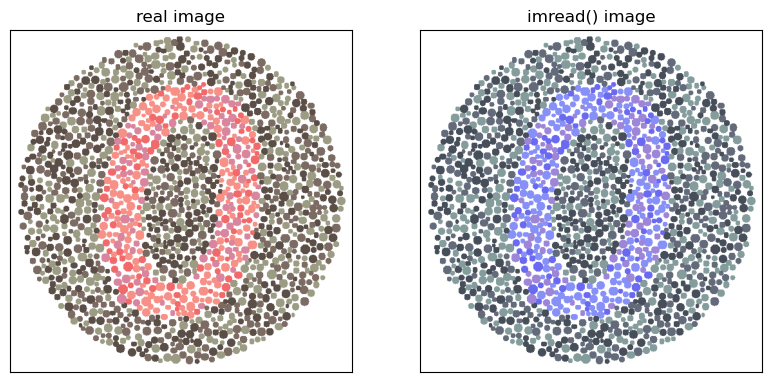

In [10]:
plt.figure(figsize=(15,15))

plt.subplot(2,3,1)
plt.title('real image'), plt.xticks([]), plt.yticks([])
plt.imshow(pic)
       
plt.subplot(2,3,2)
plt.title('imread() image'), plt.xticks([]), plt.yticks([])
plt.imshow(pic_imread)

#### Extraction des coordonnées RGB de l'image

In [11]:
def extractRGB(pic):
    r, g, b = cv2.split(pic)
    r=r.flatten()  
    g=g.flatten()  
    b=b.flatten()
    x=np.array( [[ r[i],g[i],b[i]] for i in range (len(r))] )
    x=np.unique(x,axis=0).transpose()
    return (x[0] , x[1]  ,x[2])

In [12]:
r,g,b = extractRGB(pic)
r

array([ 90, 123, 156, 216, 242, 247, 255], dtype=uint8)

## Rerésentation des contrastes des couleurs RGB 

In [13]:
def rgb_to_hex(r,g,b):
    return '#{:02x}{:02x}{:02x}'.format(r,g,b)

In [14]:
def barcolor (r, g, b ):

    color =[]
    n=len(r)

    for i in range(n):
        color.append(rgb_to_hex(r[i],g[i],b[i] )  )
        
    plt.figure(figsize=(10,0.5))

    values = [10 for i in range(n)]

    plt.bar(color, values , color=color) ;
    plt.yticks([])


    plt.show() 
    return color

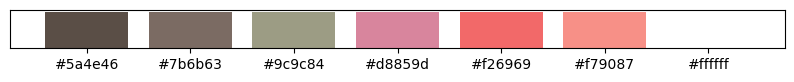

In [15]:
color=barcolor(r,g,b)

In [16]:
fig = px.scatter_3d(pd.DataFrame({'r':r,'g':g,"b":b}),  
                    x='r',y='g',z='b')
fig.update_layout(template= "ggplot2", margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# II. Préparation des données

Nous allons utiliser la fonction **`cv2.kmeans()`**, qui prend un tableau 2 dimensions en entrée, et puisque notre image d'origine est en 3 dimensions (largeur, profondeur et hauteur de 3 valeurs RGB), nous devons aplatir la hauteur et la largeur dans un vecteur unique de pixels (3 valeurs RGB) :

In [17]:
pixel_values = pic.reshape((-1, 3))
pixel_values

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [18]:
pixel_values = np.float32(pixel_values)
pixel_values

array([[255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.],
       ...,
       [255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.]], dtype=float32)

In [19]:
pixel_values.shape

(281961, 3)

# II. La modélisation  :Application de l'algorithme de K-Means 

In [20]:
def kmeans(k,criteria,pixel_values,shape):
    
        _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
        
        #Reconvertir en valeurs 8 bits
        centers = np.uint8(centers)
        labels = labels.flatten()
        
        # Convertir tous les pixels dans la couleur des centroïdes.
        segmented_image = centers[labels.flatten()]
        
        # Reconvertir les dimensions de l'image en dimensions originales.
        segmented_image = segmented_image.reshape(shape)
        
        return(segmented_image,labels)


 cv2.KMEANS_PP_CENTERS:
Lorsque cette option est activée, la méthode itère d'abord sur l'ensemble de l'image pour déterminer les centres probables, puis commence à converger.

In [21]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

**criteria** : Il s'agit du critère de fin d'itération. Lorsque ce critère est satisfait, l'itération de l'algorithme s'arrête. En fait, il s'agit d'un tuple de 3 paramètres. Ils sont ( type, max_iter, epsilon ).  

* type de critère de résiliation :  
Il dispose de 3 drapeaux, comme indiqué ci-dessous :
   * **`cv2.TERM_CRITERIA_EPS`'** : arrête l'itération de l'algorithme si la précision spécifiée, epsilon, est atteinte.
   * **`cv2.TERM_CRITERIA_MAX_ITER`** : arrête l'algorithme après le nombre d'itérations spécifié, max_iter.
   * **`cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER`** : arrête l'itération lorsque l'une des conditions ci-dessus est remplie.
* **`max_iter`** : Un nombre entier spécifiant le nombre maximum d'itérations.
* **`epsilon`** : Précision requise

In [22]:
k=7
segmented_image,labels=kmeans(k,criteria,pixel_values,pic.shape)
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

Le choix de 7 clusters n'est pas aléatoire. Chaque cluster représentera une couleur.

# III. L'évaluation: Affichage du résultat

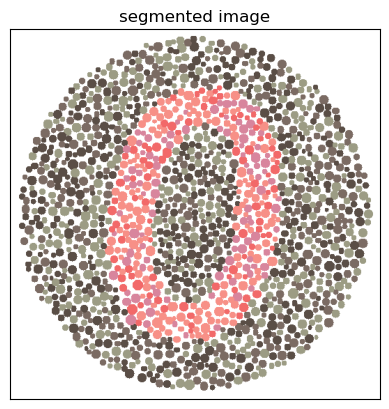

In [23]:
plt.imshow(segmented_image)
plt.title('segmented image'),plt.xticks([]), plt.yticks([])
plt.show()

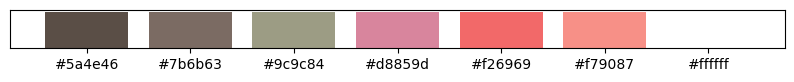

In [24]:
r1, g1 , b1 = extractRGB(segmented_image)

color=barcolor(r1,g1,b1)

In [25]:
segmented_image.shape

(531, 531, 3)

In [26]:
def aff_cluster(i,segmented_image,labels):

    im = np.copy(segmented_image)
    im=im.reshape((-1, 3))
   
    im[labels != i] = [255,255, 255]
    col= im[labels == i][0]

    return (im.reshape(segmented_image.shape),rgb_to_hex(col[0],col[1],col[2]))

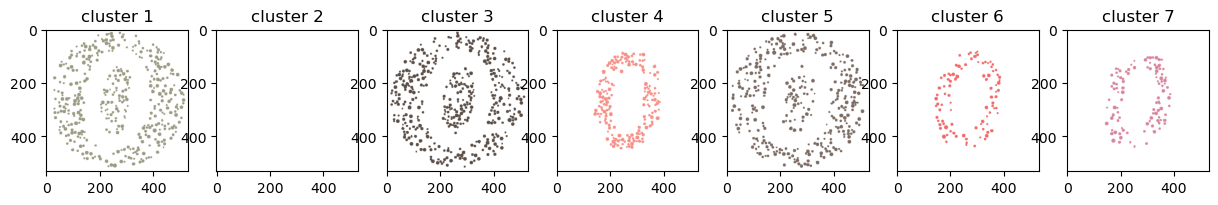

In [27]:
fig, axs = plt.subplots(1, k,figsize=(15, 15))

for i in range (k):
    axs[i].imshow( aff_cluster(i,segmented_image,labels)[0] )
    axs[i].title.set_text('cluster %i' % (i+1))

plt.show()


### Reglage de l'hyperparamètre k :

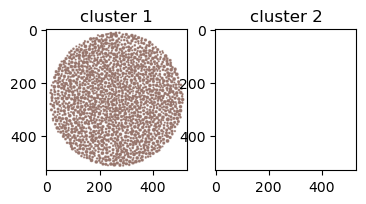

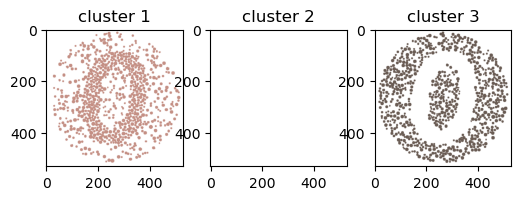

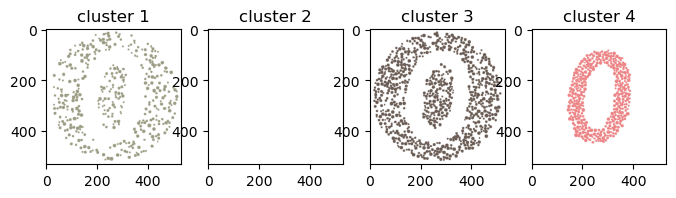

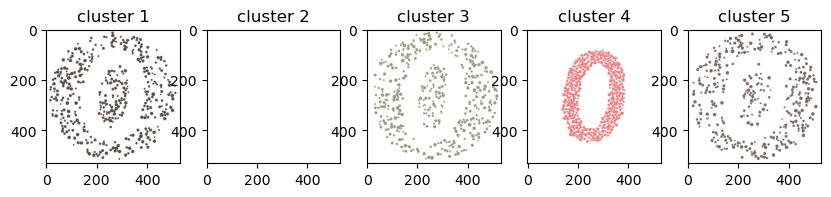

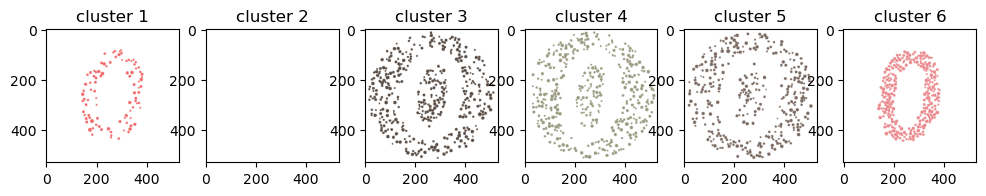

In [28]:
for k in range (2,7) :
    segmented_image,labels= kmeans(k,criteria,pixel_values,pic.shape)
    fig, axs = plt.subplots(1, k,figsize=(2*k, 10))
    for i in range (k):
        axs[i].imshow( aff_cluster(i,segmented_image,labels)[0] )
        axs[i].title.set_text('cluster %i' % (i+1))

    plt.show()

Dans la suite du travail, on considere **k=4**

In [29]:
k=4

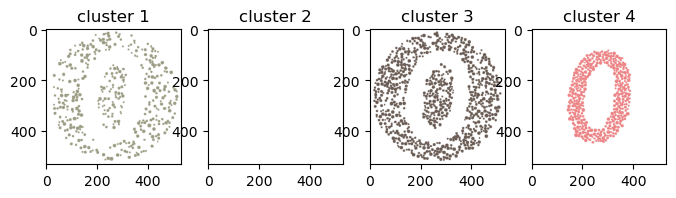

In [30]:
segmented_image,labels= kmeans(k,criteria,pixel_values,pic.shape)
fig, axs = plt.subplots(1, k,figsize=(2*k, 10))
for i in range (k):
        axs[i].imshow( aff_cluster(i,segmented_image,labels)[0] )
        axs[i].title.set_text('cluster %i' % (i+1))

plt.show()

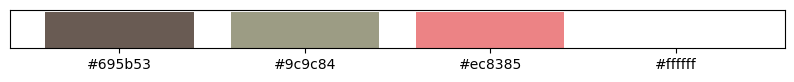

In [31]:
r1, g1 , b1 = extractRGB(segmented_image)

color =barcolor(r1,g1,b1)

### Comparaison de l'image originale et  l'image finale 


le 4eme cluster represente bien le chiffre en question, il represente la couleur rose **`#ec8385`**

In [32]:
def select_cluster(segmented_image,color,labels,type=2,k=4):
    for i in range (k):
        if aff_cluster(i,segmented_image,labels)[1]== color[type]:
            segmented_image = aff_cluster(i,segmented_image,labels)[0]
            break
    return segmented_image

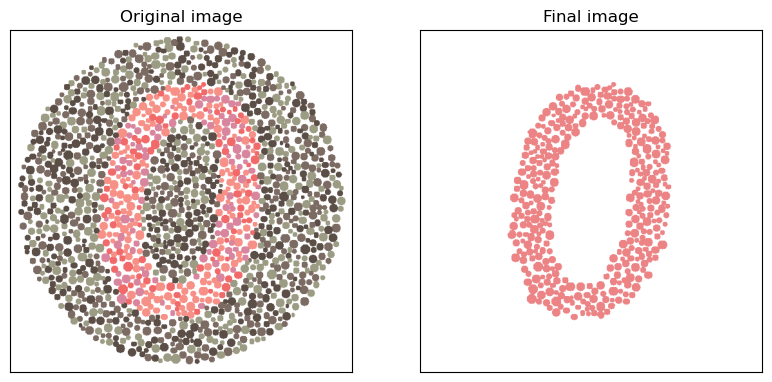

In [33]:
final_img=select_cluster(segmented_image,color,labels)
plt.figure(figsize=(15,15))

plt.subplot(2,3,1)
plt.title('Original image'), plt.xticks([]), plt.yticks([])

plt.imshow(pic)
       
plt.subplot(2,3,2)
plt.title('Final image'), plt.xticks([]), plt.yticks([])

plt.imshow(final_img)

Ainsi, on a obtenu la partie qu'on voulait séparer des autres et on peut même la modifier comme on veut. Elle est totalement indépendante des autres parties supprimées.

In [34]:
np.unique(final_img)

array([131, 133, 236, 255], dtype=uint8)

In [35]:
def modifierCouleur(final_image,couleur):
    
    couleur=couleur[1:]
    RGB=list( int    (couleur[i:i+2], 16) for i in (0, 2, 4) )

    for i in range(final_image.shape[0]):
        for j in range(final_image.shape[1]):
            if (final_image[i][j][0]!=255):
                final_image[i][j]=RGB             
            
    plt.imshow(final_image),plt.xticks([]), plt.yticks([])

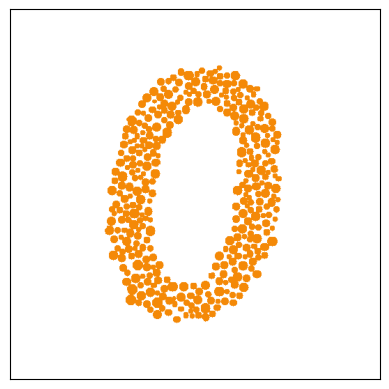

In [36]:
modifierCouleur(final_img,"#f4897")

# IV. Généralisation :


In [37]:
def segmentation(index,data):
    
    image=data.image[index]
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    k=4
    cluster=0   
    
    if (data.type_im[index] == '1') :
        k=7
        cluster=5
    elif data.type_im[index]  == "3":
        cluster=2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    segmented_image,labels=kmeans(k,criteria,pixel_values,image.shape)
    r1, g1 , b1 = extractRGB(segmented_image)
    color =barcolor(r1,g1,b1)
    
    resultat=select_cluster(segmented_image,color,labels,cluster,k)

    return (image,resultat)

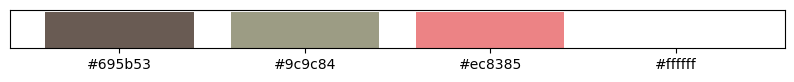

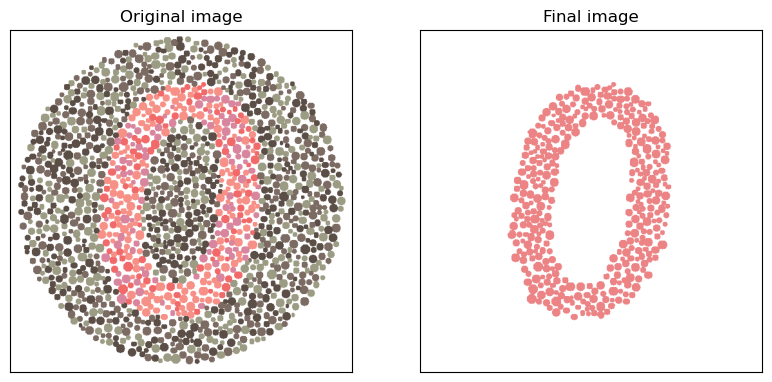

In [38]:
orig_img,final_img =segmentation(2,data)
plt.figure(figsize=(15,15))

plt.subplot(2,3,1)
plt.title('Original image'), plt.xticks([]), plt.yticks([])

plt.imshow(orig_img)
       
plt.subplot(2,3,2)
plt.title('Final image'), plt.xticks([]), plt.yticks([])

plt.imshow(final_img)

On peut également enregistrer les images obtenues:

In [39]:
#os.mkdir('Resultat')

In [40]:
#mpimg.imsave("Resultat/resultat.png", final_img)

In [41]:
#N= len(data)
#N=10
#for i in range (N):
    #mpimg.imsave("Resultat/resultat"+str(i)+".png", segmentation(i,data)[1])